In [67]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [0]:
def tensor_to_image(tensor):
  # Takes a tensor as an input
  # returns as PILLOW image
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
# Additional files for content and style images.
# Use load_image(content_path) if you want to load additional files.

#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

### **Defining helper functions.**

In [0]:
def load_img(path_to_img):
  max_dim = 500
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

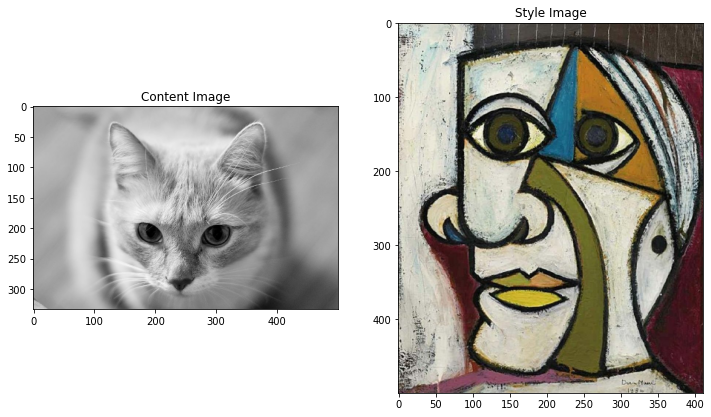

In [124]:
content_image = load_img('//content/15012101.jpg')
style_image = load_img('//content/style1.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Load VGG19 model.
The model is pretrained on ImageNet.

In [0]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [126]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

prediction_probabilities = vgg_model(x)
prediction_probabilities.shape

TensorShape([1, 7, 7, 512])

In [127]:
for layer in vgg_model.layers:
  print(layer.name)


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  vgg_model.trainable = False
  
  outputs = [vgg_model.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg_model.input], outputs)
  return model

In [130]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 500, 411, 64)
  min:  0.0
  max:  811.93286
  mean:  28.051596

block2_conv1
  shape:  (1, 250, 205, 128)
  min:  0.0
  max:  4209.3594
  mean:  171.31361

block3_conv1
  shape:  (1, 125, 102, 256)
  min:  0.0
  max:  9514.961
  mean:  161.68547

block4_conv1
  shape:  (1, 62, 51, 512)
  min:  0.0
  max:  16680.156
  mean:  633.7865

block5_conv1
  shape:  (1, 31, 25, 512)
  min:  0.0
  max:  2383.4568
  mean:  48.90747



### Define the Gram Matrix and the Loss Function.


---

> ![Representation of Gram Matrix](https://quaternionidentity.com/neural-style-transfer-pytorch-english_files/gram.png)

> ![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSKPgmaIN0e8OOJaZ1M20gBO1LfpTZsOn_pfe7OEb0gYq-bTJE0&usqp=CAU)




In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [0]:

#def gram_matrix1(tensor):
#  temp = tensor
#  temp = tf.squeeze(temp)
#  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
#  result = tf.matmul(temp, temp, transpose_b=True)
#  gram = tf.expand_dims(result, axis=0)
#  return gram


In [133]:
#print(gram_matrix(x))
#print(gram_matrix1(x))

tf.Tensor(
[[[4843.957  4151.949  3780.0215]
  [4151.949  3624.8054 3341.4856]
  [3780.0215 3341.4856 3105.7896]]], shape=(1, 3, 3), dtype=float32)
tf.Tensor(
[[[[ 7838.069   7706.048   7539.993  ...  4089.7112  4468.554
     4392.463 ]
   [ 7706.048   7576.3086  7413.1245 ...  4022.4849  4394.7793
     4320.0034]
   [ 7539.993   7413.1245  7253.551  ...  3937.929   4301.9863
     4228.865 ]
   ...
   [ 4089.7112  4022.4849  3937.929  ...  2181.024   2373.933
     2335.1873]
   [ 4468.554   4394.7793  4301.9863 ...  2373.933   2585.6345
     2543.1143]
   [ 4392.463   4320.0034  4228.865  ...  2335.1873  2543.1143
     2501.352 ]]

  [[ 7756.2827  7615.124   7607.7563 ...  4327.6436  4469.4814
     4316.673 ]
   [ 7615.124   7476.603   7469.3726 ...  4250.5415  4389.7295
     4239.776 ]
   [ 7607.7563  7469.3726  7462.1494 ...  4246.5166  4385.5664
     4235.762 ]
   ...
   [ 4327.6436  4250.5415  4246.5166 ...  2454.8892  2532.362
     2448.897 ]
   [ 4469.4814  4389.7295  4385.5664 .

## Extract style and content
Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.9, epsilon=1e-1)

In [0]:
# Custom weights for style and content updates
style_weight=1e5
content_weight=0.1

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.85,
                 'block3_conv1': 0.6,
                 'block4_conv1': 0.4,
                 'block5_conv1': 0.15}

total_variation_weight= 20

## Compute Losses:



---


> ![alt text](https://miro.medium.com/max/2464/1*2qVOACtvA3m26Q2bP4aN0A.png)
> ![alt text](https://miro.medium.com/max/2276/1*6ZqgAS5gDn25jncXDRfqog.png)
> ![alt text](https://miro.medium.com/max/2648/1*YGNtJi4rX4aHppEKYnPVaQ.png)










In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    #Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
def tv_loss(Y_hat):
    return 0.5 * (tf.reduce_mean(tf.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :])) +
                  tf.reduce_mean(tf.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1])))

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    #Extract the features
    outputs = extractor(image)
    # Calculate loss
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)
  # Determine gradients
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [178]:
tf.image.total_variation(image).numpy()

array([68150.61], dtype=float32)

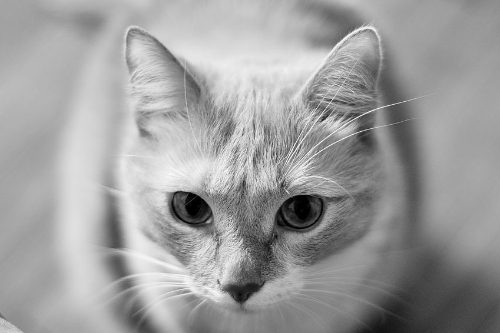

In [164]:
image = tf.Variable(content_image)
tensor_to_image(image)

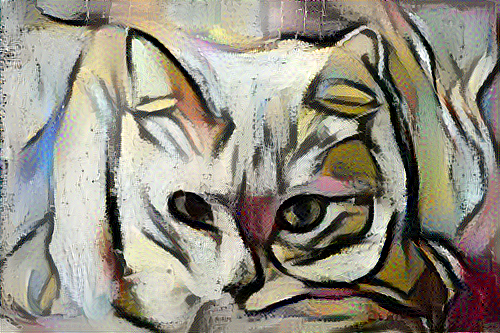

Train step: 1000
Total time: 162.4


In [191]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

After training, download the image!


In [0]:
file_name = 'stylized-image_cat.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)